In [ ]:
!pip install pyod
!pip3 install scanpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=5561e2bba01069c5bffacfc454d35d5abb646d40c12ff2f45fe15d5b6825cdb7
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 64.4 MB/s eta 0:00:00
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# norm_data.shape (9000,512) crash_data.shape (2025,512)
# crash anomaly is too many so, use only 300 of crash data (10% of normal data)
#crash_data = crash_data[0:900, :]
norm_data = normal_data[:, :]
crash_data = crash_data[:1000, :]
# split 70% for training 30% for testing
N = norm_data.shape[0]
N_tr = np.round(N * 0.7).astype(int)
train_data = norm_data[:N_tr, :]
test_data = norm_data[N_tr:, :]
train_data_label = normal_label[:N_tr]
test_data_label = normal_label[N_tr:]

train_label = np.zeros(train_data.shape[0])#,dtype="U4")
#train_label[:] = 'normal'
test_label = np.zeros(test_data.shape[0])#,dtype="U4")
#test_label[:] = 'normal'

C = crash_data.shape[0]
C_tr = np.round(C * 0.7).astype(int)
# train_data = np.concatenate([train_data, crash_data[:C_tr, :]])
# tmp = np.ones(crash_data[:C_tr, :].shape[0])
#train_data = np.concatenate([train_data, crash_data[:C_tr, :]])
tmp = np.ones(crash_data[:C_tr, :].shape[0])
#tmp[:] = 'anomaly'
#train_label = np.concatenate([train_label, tmp])

#test_data = np.concatenate([test_data, crash_data[C_tr:, :]])
#tmp = np.ones(crash_data[C_tr:, :].shape[0])
test_data = np.concatenate([test_data, crash_data[C_tr:, :]])
tmp = np.ones(crash_data[C_tr:, :].shape[0])
#tmp[:] = 'anomaly'
test_label = np.concatenate([test_label, tmp])

#train_data_label = np.concatenate([train_data_label, crash_label[:C_tr]])
test_data_label = np.concatenate([test_data_label, crash_label[C_tr:]])

print(train_data.shape, test_data.shape)
print(N, N_tr, C_tr)

(6300, 2048) (3000, 2048)
9000 6300 700


In [ ]:
from pyod.models.cof import COF
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print
from pyod.utils.data import generate_data
from torchvision import datasets, transforms
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
import numpy as np
import csv

from sklearn.model_selection import train_test_split
normal_data = np.loadtxt('/content/drive/MyDrive/normal_X3D.csv', delimiter=',', dtype='U4')
crash_data = np.loadtxt('/content/drive/MyDrive/crash_X3D.csv', delimiter=',', dtype='U4')
normal_label =np.loadtxt('/content/drive/MyDrive/normal_labeled_X3D.csv', delimiter=',', dtype='U4')
crash_label = np.loadtxt('/content/drive/MyDrive/crash_labeled_X3D.csv', delimiter=',', dtype='U4')
extra_norm_data = np.loadtxt('/content/drive/MyDrive/new_data_normal_X3D.csv', delimiter = ',', dtype='U4')
extra_norm_label = np.loadtxt('/content/drive/MyDrive/new_data_normal_labeled_X3D.csv', delimiter = ',', dtype='U4')

print('normal: ', normal_data.shape, normal_label.shape)
print('crash: ', crash_data.shape, crash_label.shape)
print('extra: ', extra_norm_data.shape, extra_norm_label.shape)

normal:  (9000, 2048) (9000,)
crash:  (2025, 2048) (2025,)
extra:  (3129, 2048) (3129,)


In [ ]:
#### shuffling the label ####
# norm_data.shape (9000,512) crash_data.shape (2025,512)
# normal_data.shape (2523,512) super_crash.shape (65)
# crash anomaly is too many so, use only 300 of crash data (10% of normal data)
print('crash is', crash_data.shape)


N = 12000
normal_data = np.concatenate([normal_data, extra_norm_data])
normal_label = np.concatenate([normal_label, extra_norm_label])

#for shuffle normal data
total_normal = np.insert(normal_data, 0, normal_label, axis = 1)
np.random.shuffle(total_normal)
normal_label = total_normal[:12000]

normal_data = np.delete(total_normal, 0, 1)
normal_data = normal_data[:12000, :]

total_crash = np.insert(crash_data, 0, crash_label, axis = 1)
np.random.shuffle(total_crash)
crash_label = total_crash[:300]

crash_data = np.delete(total_crash, 0, 1)
crash_data = crash_data[:300, :]

# split 0.75:0.25 for training and testing
N_tr = np.round(N * .75).astype(int)
train_data = normal_data[:N_tr+300, :] #normal - 9300
test_data = normal_data[N_tr+300:, :]  # normal - 2700

#label - 0 = 'inlier'
train_label = np.zeros(train_data.shape[0])#,dtype="U4")
test_label = np.zeros(test_data.shape[0])#,dtype="U4")

#label - 1 = 'outlier'
test_data = np.concatenate([test_data, crash_data[:, :]]) #anomaly - 300
tmp = np.ones(crash_data[:, :].shape[0])
test_label = np.concatenate([test_label, tmp])


# #shuffle outlier and inlier
# train_data = np.insert(train_data, 0, train_label, axis=1)
# test_data = np.insert(test_data, 0, test_label, axis=1)

# np.random.shuffle(train_data)
# np.random.shuffle(test_data)

# train_label = train_data[:, 0]
# test_label = test_data[:, 0]
# np.delete(train_data, 0, 1)
# np.delete(test_data, 0, 1)

print(train_data.shape, test_data.shape)

crash is (2025, 2048)
(9300, 2048) (3000, 2048)


In [ ]:
max_roc = 0
max_precision = 0
max_recall = 0
max_acc = 0
max_pred = np.zeros(test_label.shape[0])
max_scores = 0
max_train_pred = 0
max_train_scores = 0
max_i = 0
max_pr_auc = 0

classifier_name = 'One-Class-SVM'
#classifier = IForest(contamination = 0.1, n_estimators = 1500)
#classifier = AutoEncoder(hidden_neurons = [256, 128, 64, 3, 3, 64, 128, 256], contamination = 0.01, epochs=50, batch_size=100)
classifier = OCSVM(contamination = 0.1)
classifier.fit(train_data)

#array([0, 0, 0, ..., 0, 0, 0])
classifier.labels_

# get the prediction labels and outlier scores of the training data
y_train_pred = classifier.labels_ # binary labels (0: inliers, 1: outliers)
y_train_scores = classifier.decision_scores_ # raw outlier scores
y_train_scores.shape  #(2169,)

y_test_pred = classifier.predict(test_data)
y_test_scores = classifier.decision_function(test_data)

train_acc=np.round(accuracy_score(train_label, y_train_pred), decimals=3)
test_acc=np.round(accuracy_score(test_label, y_test_pred), decimals=3)
test_precision=np.round(precision_score(test_label, y_test_pred), decimals=3)
test_recall=np.round(recall_score(test_label, y_test_pred), decimals=3)

# evaluate and print the results
#print("\nOn Training Data:")
#print('accuracy :{acc}, '.format(acc=train_acc), end=' ')
#evaluate_print(classifier_name, train_label, y_train_scores)

print("\nOn Test Data:")
print('accuracy :{acc}, '.format(acc=test_acc), end=' ')
print('precision :{prec}, '.format(prec=test_precision), end=' ')
print('recall :{recall}, '.format(recall=test_recall), end=' ')

/usr/local/lib/python3.8/dist-packages/pyod/models/ocsvm.py:152: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X)



On Test Data:
accuracy :0.842,  precision :0.24,  recall :0.267,  

In [ ]:
evaluate_print(classifier_name, test_label, y_test_scores)

print('\nMax is precision:{prec}, recall:{recall} '.format(prec=max_precision, recall=max_recall))
roc=np.round(roc_auc_score(test_label, y_test_scores), decimals=3)
pr_auc = average_precision_score(test_label, y_test_pred)
  
max_pr_auc

One-Class-SVM ROC:0.8115, precision @ rank n:0.2525

Max is precision:0, recall:0 


0

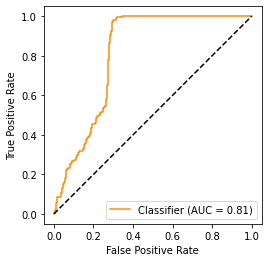

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    test_label, y_test_scores,
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

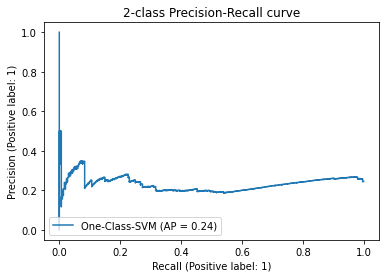

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(test_label, y_test_scores, name="One-Class-SVM")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
#사고인데 사고 아니라고한거 False Positive
#사고아닌데 사고라고 한거면 False Negative
fp = []
fn = []
for i in range(len(y_test_pred)):
  if test_label[i] == 1 and y_test_pred[i] == 0:
    fp.append(test_data_label[i])
  elif test_label[i] == 0 and y_test_pred[i] == 1:
    fn.append(test_data_label[i])


print('false positive:{pp}, false_negative:{ff}'.format(pp=len(fp), ff=len(fn)))
print(f1_score(test_label, y_test_pred))

false positive:220, false_negative:254
0.252365930599369
